# Sample Data Workthrough

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy

from scipy.ndimage.filters import gaussian_filter

pd.set_option('mode.chained_assignment', None)

### Load data

In [2]:
df = pd.read_hdf(r'C:\Users\mlori\OneDrive - Duke University\Naumann Lab\data\47\6dpf_fish47_.h5', 'a')

In [3]:
df.head(4)

,f0_x,f0_vx,f0_y,f0_vy,f0_theta,f0_vtheta,f0_theta_00,f0_theta_01,f0_theta_02,f0_theta_03,f0_theta_04,t,stimulus,trial,stim_trial,experiment,fish_id,age,bout,stim_time
0,496.426666,0.099840,995.661377,0.147022,-2.905052,-0.025164,0.051638,0.102780,0.141434,0.149419,0.099925,-0.014960,flash,0.0,0.0,47112623,47,6,NaN,0.000000
1,496.525421,0.099313,995.727478,0.108065,-2.923292,-0.021830,0.035828,0.046260,0.121361,0.180293,0.147085,-0.007978,flash,0.0,0.0,47112623,47,6,NaN,0.006206
2,496.601440,0.088093,995.718689,0.051788,-2.915061,-0.007353,0.011777,0.004759,0.013043,0.047045,0.143252,-0.001994,flash,0.0,0.0,47112623,47,6,NaN,0.012411
3,496.723877,0.104630,995.760803,0.047124,-2.828371,0.037934,0.012986,-0.013354,-0.098718,-0.068572,-0.071344,0.003989,flash,0.0,0.0,47112623,47,6,NaN,0.018617


#  

### Fish Movement Sample Trial

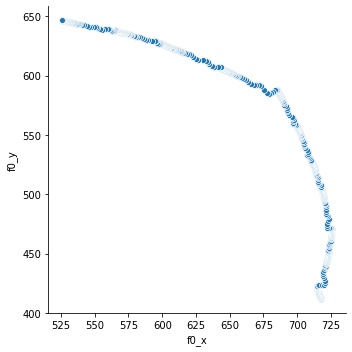

In [4]:
trial = 1
stimulus = 'Right'

# grab subset of data
sample = df[(df.trial==trial) & (df.stimulus==stimulus)]

# plot the data
sns.relplot('f0_x', 'f0_y', data=sample)

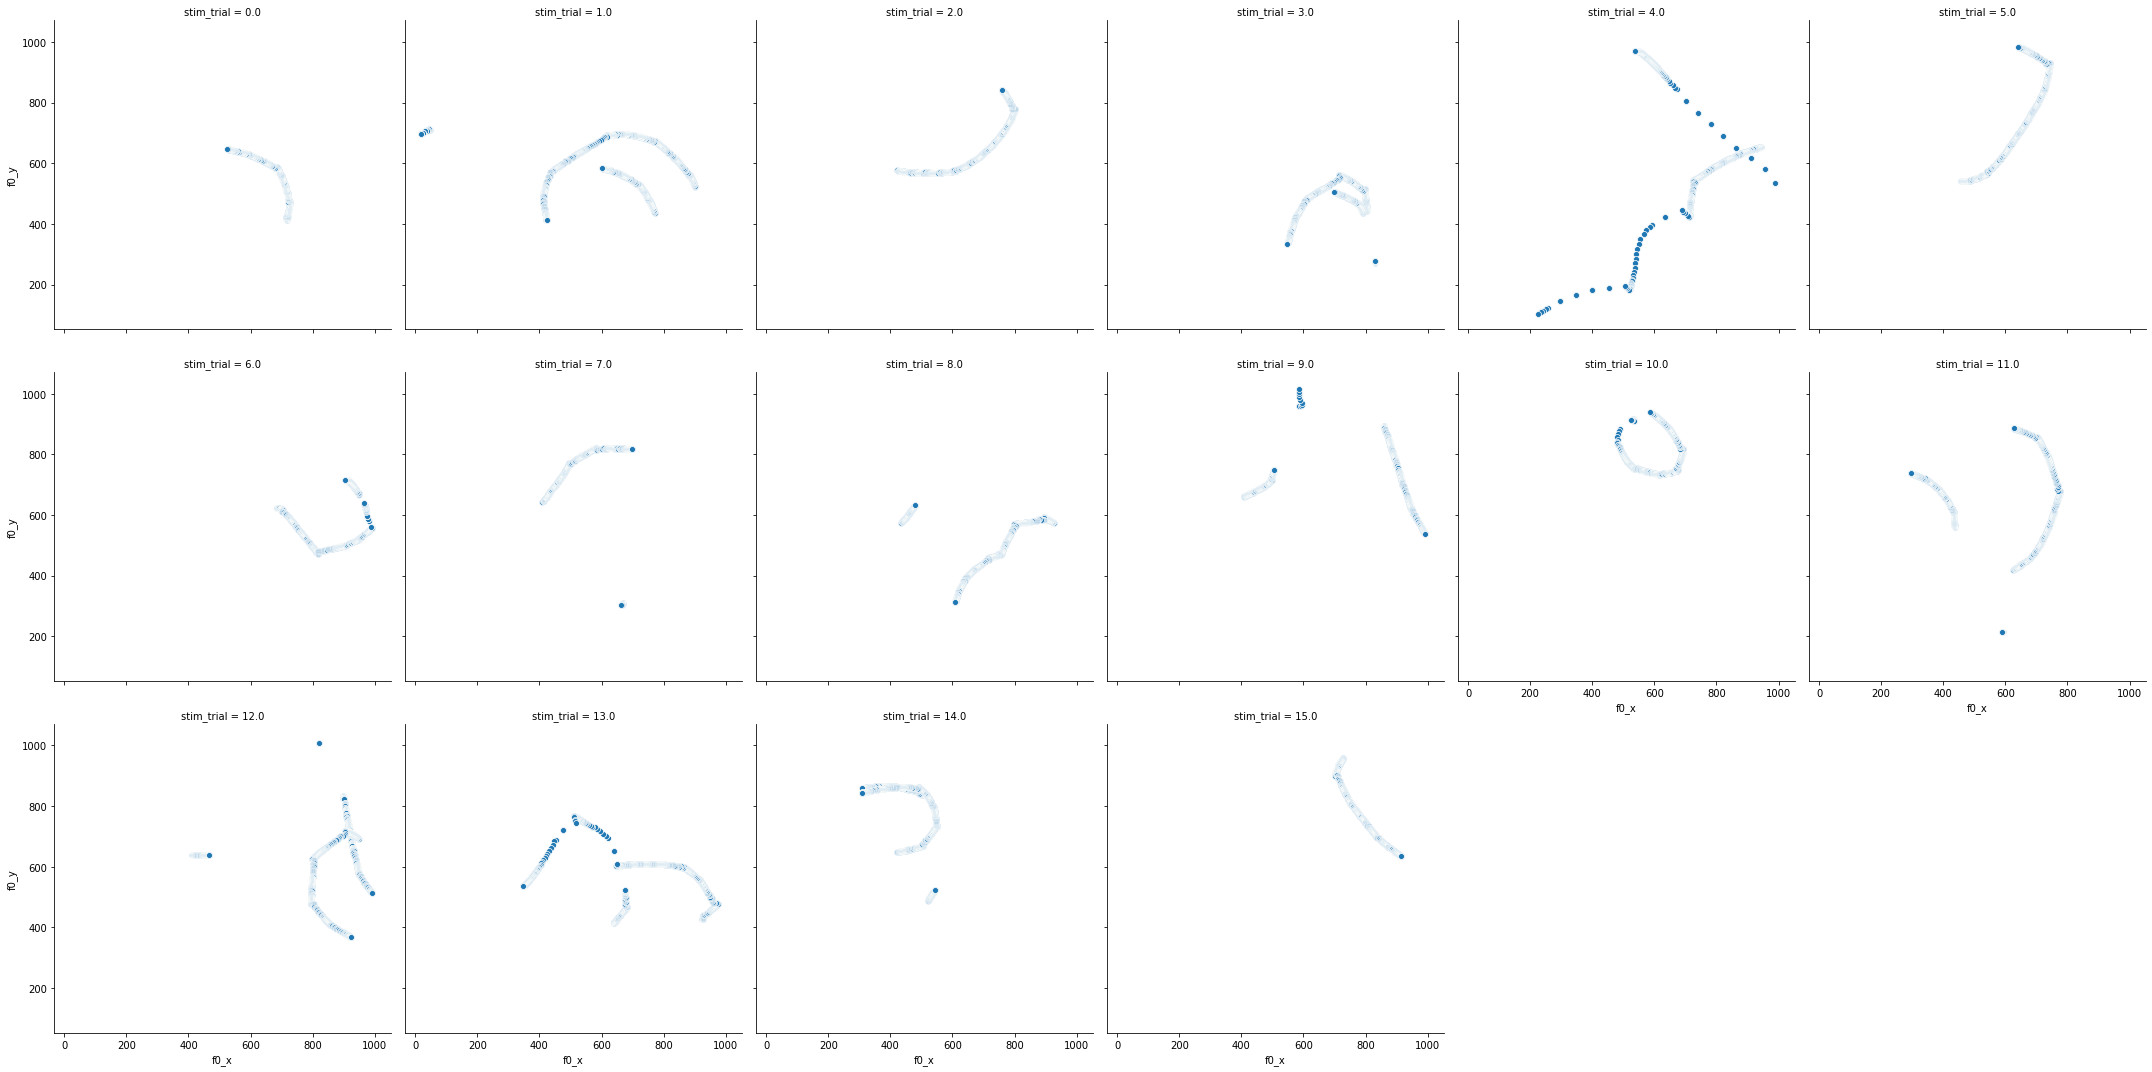

In [5]:
sns.relplot('f0_x', 'f0_y', data=df[df.stimulus=='Right'], col='stim_trial', col_wrap=6)

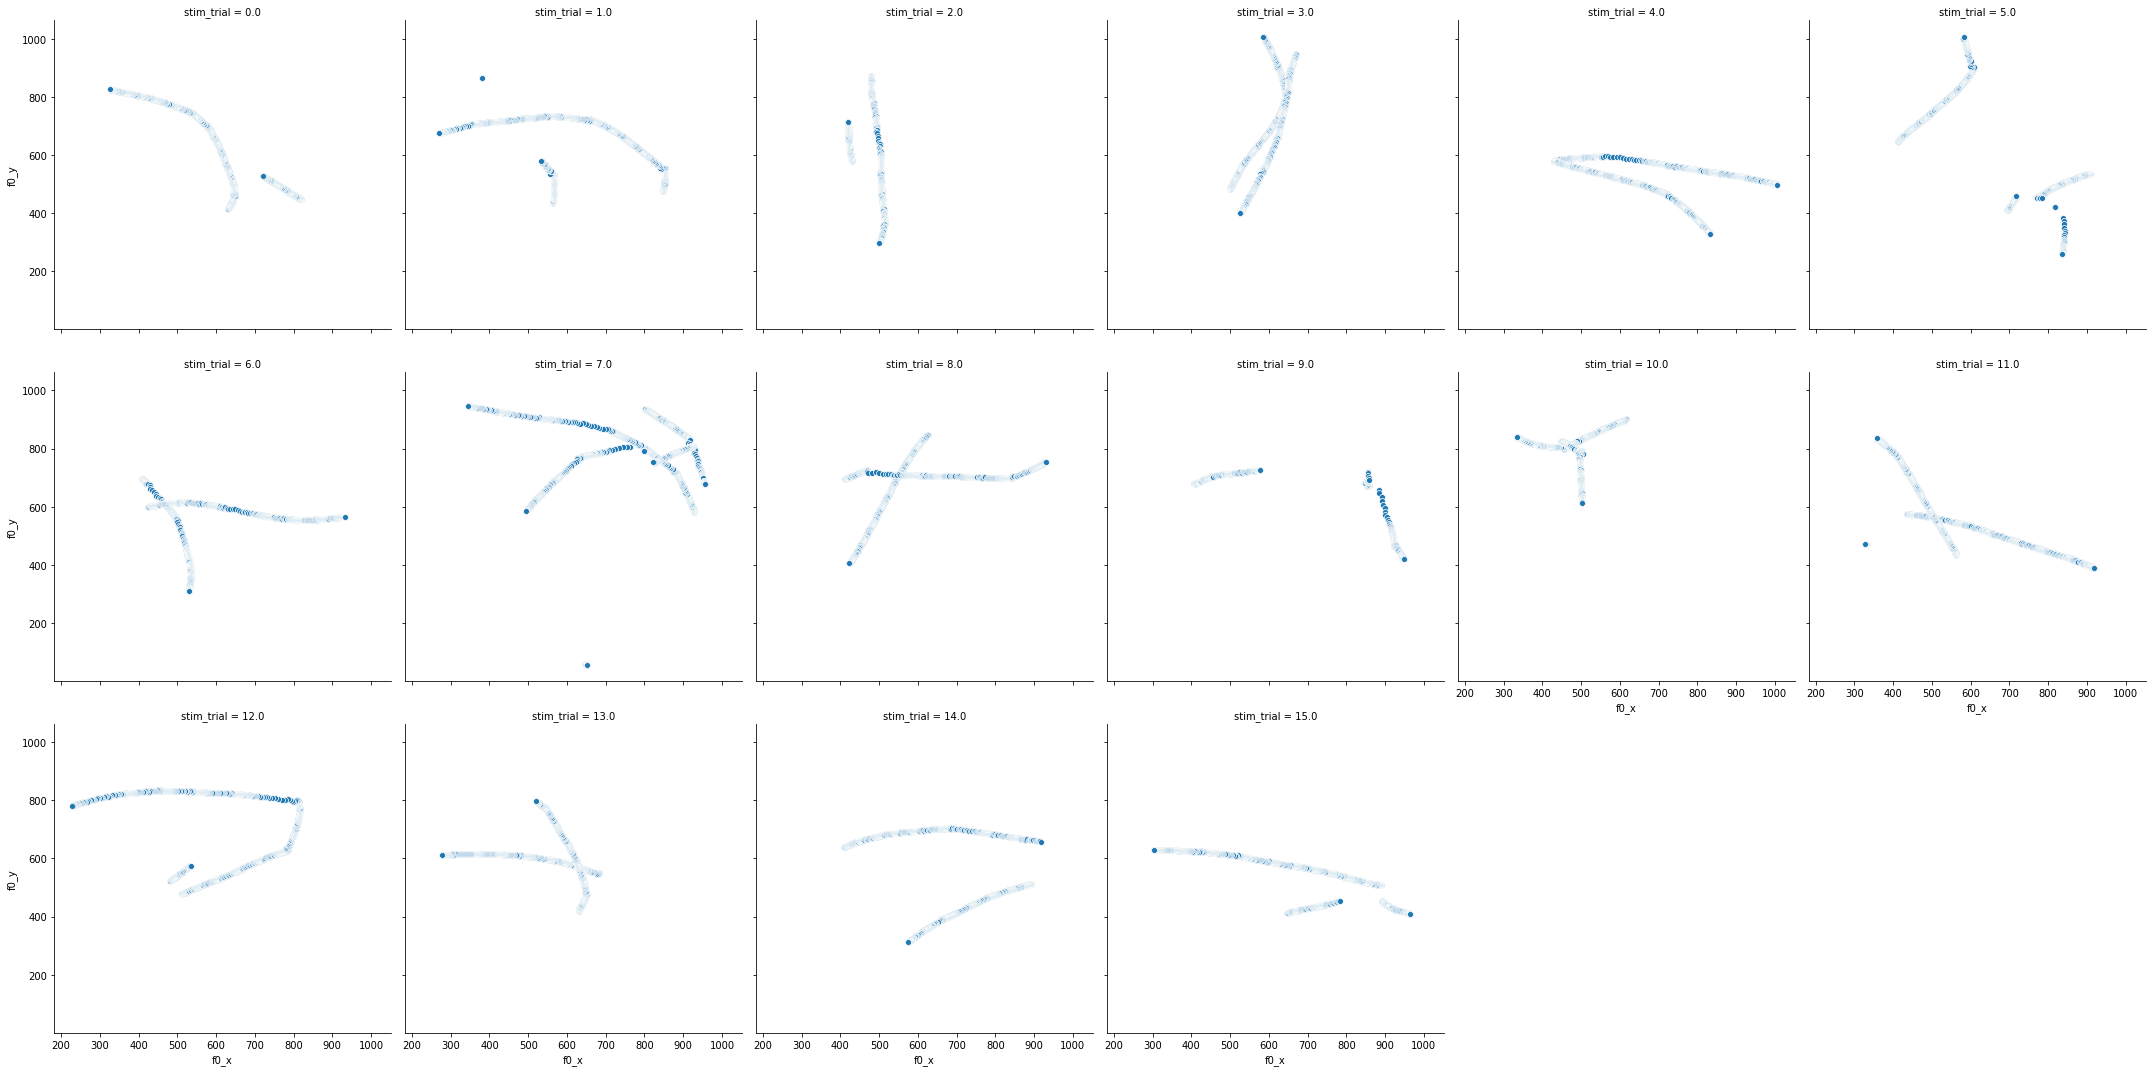

In [6]:
sns.relplot('f0_x', 'f0_y', data=df[df.stimulus=='Forward'], col='stim_trial', col_wrap=6)

### Fish Position Heat Map

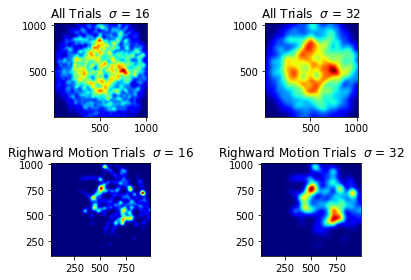

In [7]:
# small heatmap function
def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

fig, axs = plt.subplots(2, 2)

# Generate some test data
x1 = df[(df.f0_x.notna())].f0_x.values
y1 = df[(df.f0_x.notna())].f0_y.values

x2 = df[(df.f0_x.notna())&(df.stimulus==stimulus)].f0_x.values
y2 = df[(df.f0_x.notna())&(df.stimulus==stimulus)].f0_y.values

sigmas = [16, 32, 16, 32]
i = 1
for ax, s in zip(axs.flatten(), sigmas):
    if i <=2:
        img, extent = myplot(x1, y1, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("All Trials  $\sigma$ = %d" % s)
    else:
        img, extent = myplot(x2, y2, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Righward Motion Trials  $\sigma$ = %d" % s)
    i += 1
    
fig.tight_layout()
plt.show()

### Cumulative Metrics

In [8]:
def CumVals(full_df):
    full_df = full_df[full_df.stimulus != 'Centering']
    df = full_df.loc[:, ['stimulus', 'stim_trial', 'f0_x', 'f0_y', 'f0_vtheta']]

    for q in df['stimulus'].unique():
        for t in df[df.stimulus == q].stim_trial.unique():
            sub = df[(df.stimulus == q) & (df.stim_trial == t)]
            indices = sub.index
            dst = np.cumsum(
                abs(np.diff(abs(np.linalg.norm(np.stack((sub.f0_x.values, sub.f0_y.values), axis=1), axis=1)))))
            # print(len(dst), len(full_df.loc[indices[0]:indices[-1]]), len(sub))
            # print(q,t)
            try:
                full_df.loc[indices[1]:indices[-1], 'distance'] = dst
                full_df.loc[indices[1]:indices[-1], 'cum_theta'] = np.cumsum(
                    sub.loc[indices[1]:indices[-1]]['f0_vtheta'].values)
            except IndexError:
                continue
    return full_df

In [9]:
df = CumVals(df[df.f0_x.notna()])

## Distance traveled as a metric?

Text(0.5, 1, 'Right Motion')

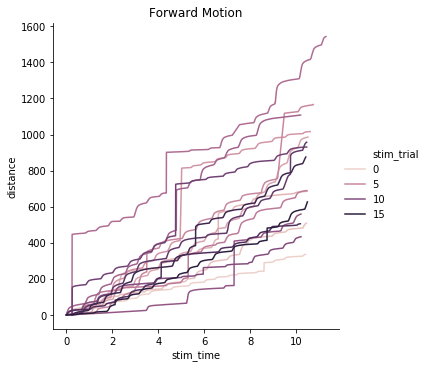

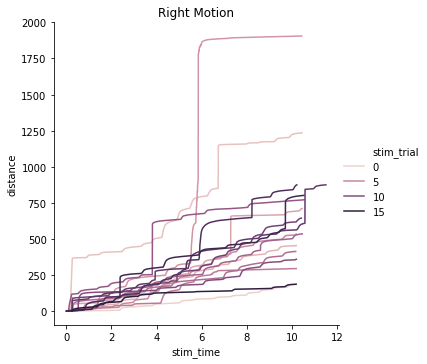

In [10]:
sns.relplot(x='stim_time', y='distance', hue='stim_trial', data=df[df.stimulus=='Forward'], kind='line')
plt.title('Forward Motion')

sns.relplot(x='stim_time', y='distance', hue='stim_trial', data=df[df.stimulus=='Right'], kind='line')
plt.title('Right Motion')

In [11]:
df[df.stimulus=='Forward'].describe()['distance']

count    26487.000000
mean       398.618828
std        315.477383
min          0.003845
25%        147.958405
50%        332.523193
75%        588.224548
max       1543.240845
Name: distance, dtype: float64

In [12]:
df[df.stimulus=='Right'].describe()['distance']

count    26259.000000
mean       346.130806
std        364.389541
min          0.000000
25%        117.228760
50%        241.539734
75%        451.643585
max       1905.722656
Name: distance, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

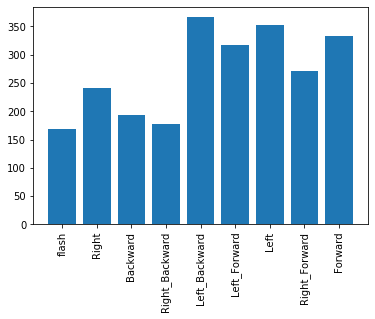

In [13]:
fifties = []
stims = []
for stim in df.stimulus.unique():
    fifties.append(df[df.stimulus==stim].describe()['distance']['50%'])
    stims.append(stim)

plt.bar(x=stims, height=fifties)
plt.xticks(rotation='vertical')


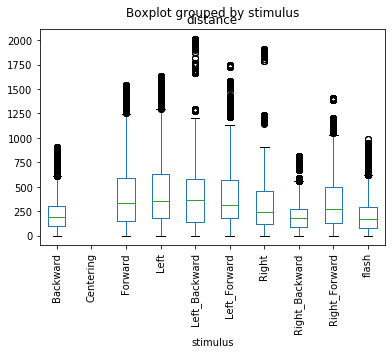

In [14]:
df.boxplot('distance', by='stimulus', rot=90, grid=False)

## Cumulative Angle as a Metric for Turning

Text(0.5, 1.0, 'Cumulative Fish Angle Over Time : Rightward Motion, single trial')

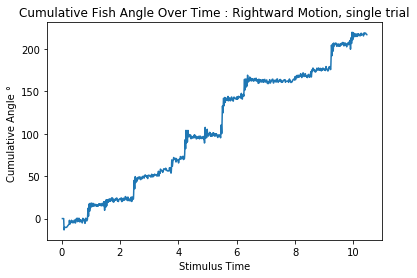

In [15]:
trial = 1
stimulus = 'Right'

thetas = df[(df.stim_trial==trial) & (df.stimulus==stimulus)].cum_theta.values*180/np.pi
times = df[(df.stim_trial==trial) & (df.stimulus==stimulus)].stim_time.values

plt.plot(times,thetas)

plt.ylabel('Cumulative Angle ° ')
plt.xlabel('Stimulus Time')

plt.title('Cumulative Fish Angle Over Time : Rightward Motion, single trial')

Text(0.5, 1.0, 'Cumulative Fish Angle Over Time : Forward Motion, single trial')

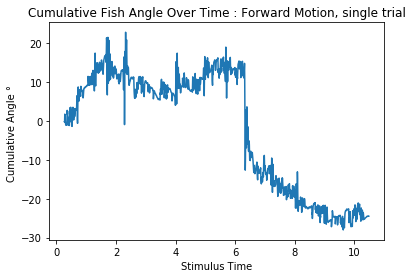

In [16]:
trial = 2
stimulus = 'Forward'

fthetas = df[(df.stim_trial==trial) & (df.stimulus==stimulus)].cum_theta.values*180/np.pi
ftimes = df[(df.stim_trial==trial) & (df.stimulus==stimulus)].stim_time.values

plt.plot(ftimes,fthetas)

plt.ylabel('Cumulative Angle ° ')
plt.xlabel('Stimulus Time')

plt.title('Cumulative Fish Angle Over Time : Forward Motion, single trial')

## Bouts as a more Quantitative Metric

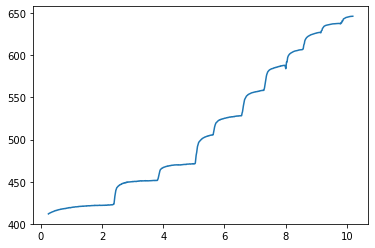

In [17]:
plt.plot(df[(df.trial==1)].stim_time.values, df[(df.trial==1)].f0_y.values)

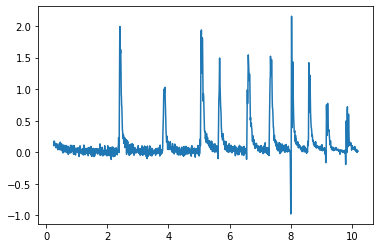

In [18]:
plt.plot(df[(df.trial==1)].stim_time.values, df[(df.trial==1)].f0_vy.values)

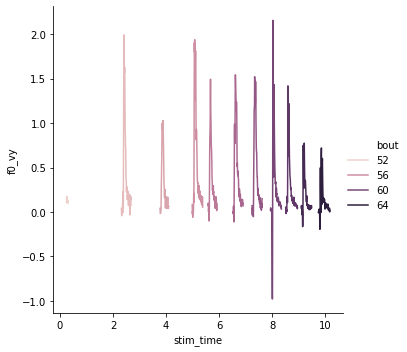

In [19]:
sns.relplot('stim_time', 'f0_vy', data=df[(df.trial==1)], kind='line', hue='bout')

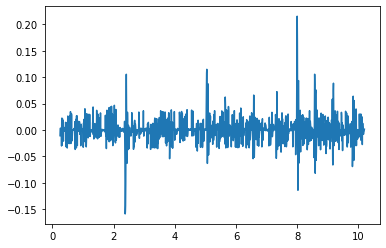

In [20]:
plt.plot(df[(df.trial==1)].stim_time.values, df[(df.trial==1)].f0_vtheta.values)

### Metrics per bout

In [21]:
def normalise_bout(bout):
    dir_init = angle_mean(bout.f0_theta.iloc[0:2], axis=0)
    coord = bout[["f0_x", "f0_y", "f0_theta"]].values
    coord[:, :2] = (coord[:, :2] - coord[:1, :2]) @ rot_mat(dir_init + np.pi)
    coord[:, 2] -= dir_init
    coord[:, 2] = reduce_to_pi(coord[:, 2])
    return coord
def angle_mean(angles, axis=1):
    """Correct calculation of a mean of an array of angles
    """
    return np.arctan2(np.sum(np.sin(angles), axis), np.sum(np.cos(angles), axis))
def rot_mat(theta):
    """The rotation matrix for an angle theta """
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
def reduce_to_pi(ar):
    """Reduce angles to the -pi to pi range"""
    return np.mod(ar + np.pi, np.pi * 2) - np.pi

In [22]:
def plot_bout(i_bout, bouts, clear_axes=False):
    normbout = normalise_bout(bouts[bouts.bout==i_bout])
    if clear_axes:
        for ax in axes:
            ax.clear()
    ax = axes[0]
    ax.plot(normbout[:,0], normbout[:,1])
    ax.plot([0,0,1], [-1.5,-2.5,-2.5], color='k', lw=0.5)
    ax.axis("off")
    ax.text(0.0, 1.8, "Trajectories")
    ax.text(0.1, -2.4, "1 mm")
    ax.set_aspect(1)
    ax.set_ylim(-3, 2.5)
    ax.set_xlim(-0.5, 3)
    
    sel = bouts[bouts.bout==i_bout]
    axes[1].plot(sel["t"]-sel["t"].values[0], np.sqrt(sel["f0_vx"]**2+sel["f0_vy"]**2))
    axes[1].set_ylabel("Velocity magnitude [mm/s]")
    axes[2].plot(sel["t"]-sel["t"].values[0], np.unwrap(sel["f0_theta"]-sel["f0_theta"].values[0]))
    axes[2].set_ylabel("Relative angle [rad]")
    for ax in axes[1:]:
        ax.set_xlabel("Time [s]")

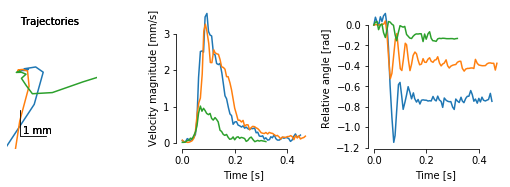

In [23]:
sel_bouts = [4,190,430,]

fig, axes = plt.subplots(1, 3, figsize=(7.5,2.7))
for i_bout in sel_bouts:
     plot_bout(i_bout, df, clear_axes=False)
for ax in axes[1:]:
    sns.despine(ax=ax, trim=True)
fig.tight_layout()
plt.show()

In [24]:
alldf = []
boutdf = df[df.bout.notna()]

dsts = []
ang = []
stim = []
trials = []
time_tots = []

for b in boutdf.bout.unique():
    sub = boutdf[boutdf.bout==b]
    trials.append(sub.trial.values[0])
    time_tots.append(boutdf[boutdf.trial==sub.trial.values[0]].stim_time.values[-1])
    try:
        final = normalise_bout(sub)[-1]
        dsts.append(np.linalg.norm(final[0:2]))
        ang.append(final[-1] * 180 / np.pi)
        stim.append(sub.stimulus.values[0])
    except IndexError:
        print('error on:', b)

extracted_df = pd.DataFrame({'stimulus':stim, 'angle':ang,'distance':dsts, 'trial':trials, 't_tot':time_tots})
alldf.append(extracted_df)

In [25]:
bout_df = pd.concat(alldf)

In [26]:
bout_df.head()

,stimulus,angle,distance,trial,t_tot
0,flash,-1.508024,35.112194,0.0,7.837616
1,flash,-119.265990,152.016129,0.0,7.837616
2,flash,-44.226486,100.902039,0.0,7.837616
3,flash,-34.995827,60.897007,0.0,7.837616
4,flash,-44.953710,51.106823,0.0,7.837616


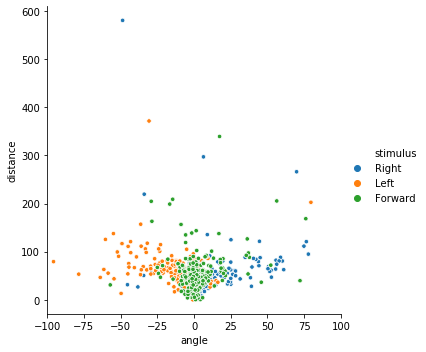

In [27]:
subset = bout_df[(bout_df.stimulus=='Forward')|(bout_df.stimulus=='Right')|(bout_df.stimulus=='Left')]
sns.relplot('angle', 'distance', data=subset, hue='stimulus', s=20)
plt.xlim(-100,100)
plt.show()

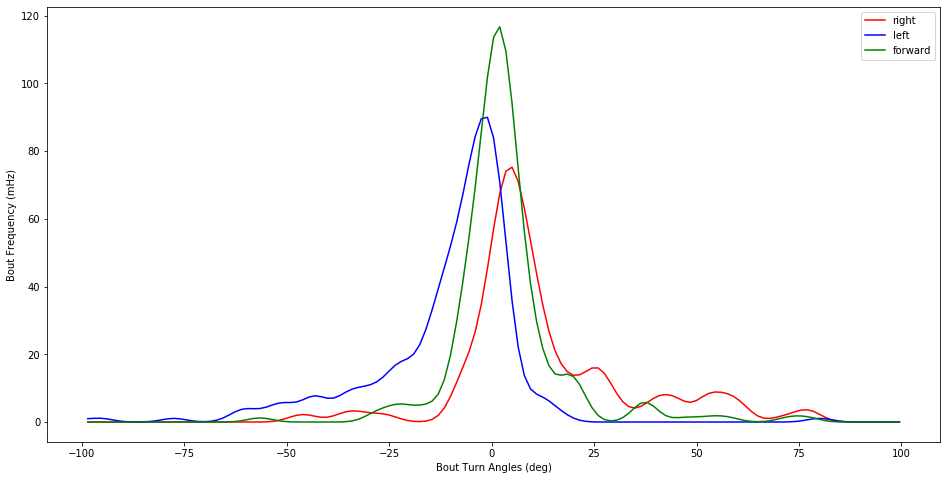

In [28]:
stim="Right"

_data = bout_df[(bout_df.stimulus==stim)]
stim_timer = []
for t in _data.trial.unique():
    t_data = _data[_data.trial==t]
    stim_timer.append(t_data.t_tot.values[0])

_bins = np.arange(-100,100,1.5)
hist, bins = np.histogram(_data.angle.values, _bins)
hist_smooth = scipy.ndimage.filters.gaussian_filter1d((1000 * hist) / sum(stim_timer), sigma=2)

right = hist_smooth

## Leftward, you could loop this but the copy paste works
stim="Left"

_data = bout_df[(bout_df.stimulus==stim)]
stim_timer = []
for t in _data.trial.unique():
    t_data = _data[_data.trial==t]
    stim_timer.append(t_data.t_tot.values[0])

_bins = np.arange(-100,100,1.5)
hist, bins = np.histogram(_data.angle.values, _bins)
hist_smooth = scipy.ndimage.filters.gaussian_filter1d((1000 * hist) / sum(stim_timer), sigma=2)

left = hist_smooth

## Forward, you could loop this but the copy paste works
stim="Forward"

_data = bout_df[(bout_df.stimulus==stim)]
stim_timer = []
for t in _data.trial.unique():
    t_data = _data[_data.trial==t]
    stim_timer.append(t_data.t_tot.values[0])

_bins = np.arange(-100,100,1.5)
hist, bins = np.histogram(_data.angle.values, _bins)
hist_smooth = scipy.ndimage.filters.gaussian_filter1d((1000 * hist) / sum(stim_timer), sigma=2)

fwd = hist_smooth


plt.figure(figsize=(16,8))
plt.plot(bins[1:], right, color='red', label='right')
plt.plot(bins[1:], left, color='blue', label='left')
plt.plot(bins[1:], fwd, color='green', label='forward')

plt.legend()
plt.xlabel('Bout Turn Angles (deg)')
plt.ylabel('Bout Frequency (mHz)')

plt.show()
# l, caps, c = plt.errorbar(bins[1:], hist_smooth, errorevery=3, linewidth=3, capsize=2, capthick=0.5, elinewidth=1)
# for cap in caps:
#     cap.set_marker("")
# plt.legend()
# plt.show()